# Lab 8

## Background

Genome sequencing is a very useful technique in biology, but a long genome has to be split into small segments for the sequencer to read. In the algorithm, short reads are firstly compack into "contigs", and then concatenate into a whole one.

## Locating the data

The data can be found in `/data/lab8`. The data set includes 3 parts: `illumina_reads_R1.fastaq` and `illumina_reads_R2.fastaq` are short paired-end reads, and `pacbio_reads.fastq`. It is expected that illumina short sequences have **smaller error rate** but PacBio has **higher**.

`screen` is a useful command when you are working on remote. The break of ssh connection will cause any process in that session to be killed. `nohup` will also do the work, but screen is better because it saves the whole session and it would be very comvenient if you can restore that.

To start screen, just type `screen`. If you want to leave, hit `ctrl + A` then hit `D` for dettach. If you want to restore session, first use `screen -ls` to list all sessions in the background, and then use `screen -r SESSION_NUMBER` to restore that.

In the screen session, type the command:

```
spades -t 1 -1 /data/lab8/illumina_reads_R1.fastq -2 /data/lab8/illumina_reads_R2.fastq --pacbio /data/lab8/pacbio_reads.fastq -o ./chromosome.output
```
I also used `time` to record the time for running. Here is time time spent on assembly:

In [3]:
rec_file = open('chromosome.total_time', 'r')
for line in rec_file:
    print(line)



real	956m7.781s

user	939m30.203s

sys	12m24.153s



It took around 16 hours to run.

## Generate assembly statistics

After the assembly, the file `conrigs.fasta` and `scaffolds.fasta` are present in the output folder. Contigs are contiguous sequences that are assembled from the reads. Scaffolds are sets of contigs connected together in order.

N50 is a statstics defined as if you are summing up the length of contigs in a ordered set of all contigs from the longest to the shortest. When you sum a particular contig, the sum of length exeeds 50% of the total length of all contigs. Then the length of this contig is N50.

In [10]:
import subprocess

proc = subprocess.run(['assembly-stats', 'chromosome.output/contigs.fasta'],\
                     input=None, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
for line in proc.stdout.decode().split('\n')[:3]: 
    print(line)

stats for chromosome.output/contigs.fasta
sum = 6678635, n = 176, ave = 37946.79, largest = 414008
N50 = 234690, n = 11


In [11]:
import subprocess

proc = subprocess.run(['assembly-stats', 'chromosome.output/scaffolds.fasta'],\
                     input=None, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
for line in proc.stdout.decode().split('\n')[:3]: 
    print(line)

stats for chromosome.output/scaffolds.fasta
sum = 6678655, n = 174, ave = 38383.07, largest = 414008
N50 = 234690, n = 11


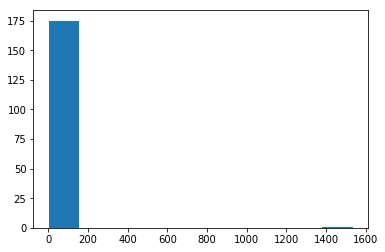

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt
import re

coverage_list = []
contig_file = open('chromosome.output/contigs.fasta')
for line in contig_file.readlines() :
    if line[0] == '>' :
        coverage = float(re.findall(r"(?<=_cov_)[0-9.]+", line)[0])
        coverage_list.append(coverage)
_ = plt.hist(coverage_list)

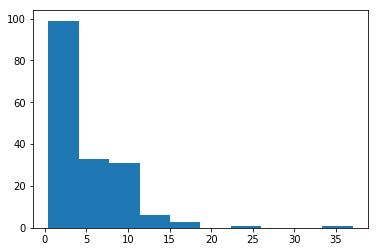

In [27]:
filtered_list = []
for coverage in coverage_list:
    if coverage < 100 :
        filtered_list.append(coverage)
_ = plt.hist(filtered_list)

The first graph shows the histograph of all contigs. To show more detail in short contigs region, I have filtered out all contigs that are longger than 100.

This shows neither a uniform distribution nor a Gaussian distribution. It looks more like a geometry distribution. It is also not a multimodal one and only has 1 peak.Coverage of a segment is associated with its length: longer segments also have higher coverage. If the segments have the length twice of average, then it could have twice as high coverage. Also, The segment could repeat twice in the genome.

## Identify the taxon

To identify your genome, you must

1. scan over the entire genome to locate copies of the 16S ribosomal RNA gene
2. extract the 16S rRNA genes from your assembly
3. compare these genes to a database of known 16S rRNA genes.

We choose the 16S rRNA because it is conserved throughout all bacteria, so it can serve as a taxon marker. The first step is achieved by using the `rna_hmm3.py` programme. Run the command as followed:

```sh
rna_hmm3.py -i chromosome.output/contigs.fasta -o rrna.gff
```

The programme uses a Hidden Markov Model to predict rRNA position. Then use `bedtools getfasta` to extract nucleic acid sequences of 16S rRNA from contigs.
Run the following command:


```sh
bedtools getfasta -fi chromosome.output/contigs.fasta -bed rrna.gff > rrna.fasta
```

After getting the 16S rRNA sequence, upload the sequence to [Ribosomal Database Project's SeqMatch tool](http://rdp.cme.msu.edu/seqmatch/seqmatch_intro.jsp) to identify the taxon this genome belongs to. The result is pasted below:

```
rootrank	Root	domain	Bacteria	phylum	"Proteobacteria"	class	Gammaproteobacteria	order	Pseudomonadales	family	Pseudomonadaceae	genus	Pseudomonas
```

So basically, to genus level, this genome belongs to a _Pseudomonas_.If one looks carefully into the textfile generated by RDP seqmatch, he will see lots of matchings each stands for the guess of a species from a piece of the rRNA. We only focus on the overall result here.

## Genome annotation

RAST (Rapid Annotation using Subsystem Technology) and BASys (Bacterial Annotation System) are two online annotation services. Annotation programs rely on the taxon of the genome to give a guess. Register RAST and upload the contig FASTA file to both sited and wait in patience.

After about a day's wait, I got the results of from RAST. RAST offered me genbank file with all features, which I can open with vim and search the features very quick locally, or I can use the `SEED` browser to find the _subsystem_ and features I need.

Just for an overview, I pasted a screenshot of __subsystem statistics__ here.

![subsystem statistics](./pseudomonas_annotation_seed.png)

## Research and write-up

In demonstrating understanding the microbe with its feature annotated genome, I have picked some of the topics listed in the lab requirement, as well as some of my own. The discussion is as followed:

1. What environment do relatives of your bacterium live in? Is there evidence of adaptation to the environment in the genome?

    Going the wikipedia of pseudomonas, I picked up some of the features related to their habitats. _Pseudomonas_ covered very wide nitches, but one thing in common is they are all aerobic bacteria, not very interestingly. It is expected to find at least __catalase__ in our genome, which metabolizes the toxic hydrogen peroxide in cells.

    Not suprisingly, I found catalase in the genome along with a bunch of other protein used to protect the bacteria from reactive oxygen species:


Name | Function | Reaction
--- | --- | ---
sodA	|Manganese superoxide dismutase (EC 1.15.1.1)	|R00275
sodB	|Superoxide dismutase [Fe] (EC 1.15.1.1)	|R00275
sodC	|Superoxide dismutase [Cu-Zn] precursor (EC 1.15.1.1)	|-
HPII	|Catalase (EC 1.11.1.6)	|R00009
HPI	|Peroxidase (EC 1.11.1.7)	|-
CCP	|Cytochrome c551 peroxidase (EC 1.11.1.5)	|R00017
    
2. Some _Pseudomonas_ is virulent and can also cause human diseases. What evidence can be found in this genome to prove the strain is virulent, if any.

    It is interesting to notice that some _Pseudomonas_ are **virulent** to animals and humans. According to review papers, **Pyoverdine** is a small molecule that is shown to play a role in _Pseudomonas_ virulence. Also, **Alkaline protease** secrected by _Pseudomonas_ is clear to play a role in corneal infections. I have tried to find associated genes in the genome and here is what I got:
    
Name and Function | Cordinates
--- | ---
Pyoverdine chromophore precursor synthetase PvdL @ Siderophore biosynthesis non-ribosomal peptide synthetase modules| 84936..97919
Pyoverdine biosynthesis related protein PvdP | 199458..201083
Pyoverdine sidechain non-ribosomal peptide synthetase PvdI @ Siderophore biosynthesis non-ribosomal peptide synthetase modules | 276080..283909

And also:

Name and Function | Cordinates
--- | ---
Alkaline proteinase inhibitor precursor | 44601..45023
Alkaline induced inner membrane protein Alx | 213380..214351
Phosphodiesterase/alkaline phosphatase D | 142005..143546

Which proves __pyoverdine biosynthesis__ genes and __alkaline proteinase__ genes are present in this bacteria. It is quite possible that it is a virulent strain as well.

> E. Kipnis, T. Sawa, and J. Wiener-Kronish. "Targeting mechanisms of Pseudomonasaeruginosa, pathogenesis." Médecine et Maladies Infectieuses 36.2(2006):78-91.

3. Based on its genome, is your bacterium auxotrophic for any amino acids? Are its closest relatives also auxotrophic for these?

    In order to examine what amino acid this bacteria synthesis, I have took a screenshot of all genes associated with amino acid synthesis:

    ![pseudomonas aa synthesis](./pseudomonas_aa_auxotrophic.png)
    
    There is at least one gene related with every class of AA biosynthesis gene. I would suggest this _Pseudomonas_ undergoes no AA auxotrophy for now, but the conclusion does rely on further examination on each AA biosynthesis related gene.
    
4. CRISPR-Cas9 is so hot right now. Does your genome have a CRISPR system? Can you determine where the spacer sequences originated from?

    Unfortunately, no CRISPR related genes are found in this genome. Consulting Wikipedia, CRISPR related genes exist in approximately 50% of all bacteria genome, but not in this one. Also accroding to Wikipedia, CRISPR system includes a bunch of genes including __Cas3, Cas9, Cas8abc, Cas13, Cse1&2, Csy1&2&3, Cpf1, Csf1__, etc. However, none of above gene is found.
    
5. Type IV pili can extend and retract by the cell which help bacteria to glide through a surface. Does this pili system exist in this bacteria?

    Taken MCB 112, I have learnt at least 5 proteins involve in __type IV pili system__, which are __PilA, PilG, PilF, PilT and PilQ__. Among which PilA serves as the monomer of a pilus (known as pillin), PilF helps monomer assembly and PilT controls the extention and contraction of pili. PilQ is the position where PilA assembles and PilQ opens a pore on the outer membrane which allows pili to move. Here are the type IV related genes I found in this genome:
    
Name and Function | Cordinates
--- | ---
Twitching motility protein PilT | 218695..219729
twitching motility protein PilG | 227592..227996
Type IV pilus biogenesis protein PilF | 39844..40602
Type IV pilin PilA | 77589..78011
Type IV pilus biogenesis protein PilQ | 147463..149538

It is at all not surprising to see these type IV pili protein exists in the genome, as pili is common among almost every kind of bacteria. However, some annotations interest me such as PilQ and PilG also play a role in pili synthesis.